<a href="https://colab.research.google.com/github/neuralnetworksrs/Tarea-1/blob/master/Tarea_1_Parte_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>

**Temas**  

* Entrenamiento de redes *Feed-Forward* vı́a GD y variantes (SGD, mini-*batches*), *momentum*, regularización y tasa de aprendizaje adaptiva.
* Rol de capas ocultas y mayor profundidad (*Deep Learning*).
* Diseño y entrenamiento de Redes Neuronales Convolucionales (CNNs).
* Aplicaciones de las Redes Neuronales Convolucionales
* Técnicas de regularización: *Dropout* y *Batch Normalization* 

<hr style="height:2px;border:none"/>
La tarea se divide en secciones:

[1.](#primero) Red Neuronal *Feed Forward* para Detectar Exoplanetas  
[2.](#segundo) *Deep Networks*  
[3.](#tercero) Redes Convolucionales en Imágenes  
[4.](#cuarto) CNN *vs* RNN Prediciendo el Ozono Atmosférico

## 1. Red Neuronal *Feed Forward* para Detectar Exoplanetas
---

Las Redes Neuronales Artificiales (ANN) son un tipo de modelo de aprendizaje que, con el suficiente número de capas, debiera poder aproximar cualquier función. Hoy en día se han aplicado a numerosos problemas, ya que tienen la ventaja de ser bastante dinámicas en su construcción y poder ser entrenadas con unicamente *backpropagation*, obteniendo un buen desempeño. Los modelos de aprendizaje son aplicados a diferentes ámbitos en donde, en algunos casos, automatizan extensivos procesos manuales de expertos, como lo que veremos a continuación.

<img src="https://www.cfa.harvard.edu/~avanderb/tutorial/HAT-P-3b.gif" title="YOLO" width="30%"/>

En esta sección trabajaremos con un dataset de astronomía, **Kepler KOI** [[1]](#refs), en el cual podrán experimentar con la detección de exoplanetas a través de *features* extraídas de las curvas de luz (tránsito de los planetas sobre su estrella madre) y metadatos de la observación (planeta, estrella y curvas de luz). Para más información sobre los metadatos visite el siguiente __[link](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html)__. La tarea es determinar si un posible candidato a exoplaneta (en base a una previa identificación/selección de eventos que sobrepasan un cierto *treshold*) corresponde efectivamente a un exoplaneta o no.

---
En primer lugar cargue todos los datos trabajados por [[2]](#refs), los cuales se encuentran adjuntados con el enunciado. Además separe en entrenamiento y pruebas.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas  as pd
import numpy as np
df_sets = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/data/koi_sets_unb.csv")
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
print(mask_train)
df_labels = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/data/koi_labels.csv")
df_X = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/data/koi_light_curves_X.csv")
df_labels_train = df_labels[mask_train]
df_labels_test = df_labels[mask_test]
df_X_train = df_X[mask_train]
df_X_test = df_X[mask_test]

[False  True  True ...  True False False]


A continuación cree las matrices que trabajará y servirán para entrenar su modelo neuronal, la etiqueta binaria (0 o 1) y la matriz numérica de entrada, imputando el estadístico de la mediana sobre los valores nulos.

In [0]:
y_train = ((df_labels_train["NExScI Disposition"]=="CONFIRMED")*1).values
y_test = ((df_labels_test["NExScI Disposition"]=="CONFIRMED")*1).values
df_X_train = df_X_train.reset_index(drop=True)
df_X_test = df_X_test.reset_index(drop=True)
df_X_train.fillna(df_X_train.median(), inplace=True)
df_X_test.fillna(df_X_test.median(), inplace=True)
X_train = df_X_train.values[:,1:]
X_test = df_X_test.values[:,1:]

**a)** Explore los datos trabajados, ya sea con estadísticos simples o con gráficos como histogramas y/o boxplots. Comente sobre el problema enfrentado, es decir, la tarea de transformar un vector $X$ en un valor categórico (0 o 1).

In [0]:
columns_names = df_X_train.columns[1:]
print(columns_names)
print(X_train.shape)
print(X_test.shape)
df_X_train.describe()

Index(['Minimum', 'Maximum', 'Mean', 'Std', 'IQR', 'Skew', 'Kurtosis', 'Q1',
       'Q2', 'Slope', 'Amplitude', 'MAD', 'Residual Bright Faint Ratio',
       'Median', 'Period', 'Time of Transit Epoch', 'First Transit Time (BJD)',
       'Impact Parameter', 'Duration', 'Transit Depth', 'r/R',
       'Fitted Stellar Density', 'Planet Radius', 'Semi-major Axis',
       'Inclination', 'Teq', 'Insolation Flux', 'a/R', 'Limb Darkening Coeff1',
       'Limb Darkening Coeff2', 'Limb Darkening Coeff3',
       'Limb Darkening Coeff4', 'Teff', 'log(g)', 'Metallicity',
       'Stellar Radius', 'Stellar Mass', 'Max single event sigma',
       'Max Multievent sigma', 'Transit Model SNR', 'KOI count'],
      dtype='object')
(4692, 41)
(1565, 41)


,Minimum,Maximum,Mean,Std,IQR,Skew,Kurtosis,Q1,Q2,Slope,...,Limb Darkening Coeff4,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count
count,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4.692000e+03,...,4692.0,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000
mean,-66.492676,23.987692,-0.142418,4.136842,0.333109,-9.386612,211.410321,-0.105753,0.017978,1.483853e-07,...,0.0,5744.338875,4.296402,-0.132632,1.900540,1.036185,287.105781,1676.133027,433.699680,1.460358
std,274.391875,112.019945,0.501607,18.127797,2.060592,9.112166,539.593897,0.450513,0.366224,7.449019e-06,...,0.0,860.487363,0.457178,0.283833,7.311725,0.372291,1001.727968,5421.050203,1052.012721,0.950673
min,-8446.637695,0.000000,-13.658888,0.000000,0.000000,-117.225060,-3.000000,-11.479470,-1.961110,-1.280449e-04,...,0.0,2703.000000,0.047000,-1.980000,0.118000,0.000000,2.539000,7.105000,0.000000,1.000000
25%,-7.086795,0.167940,-0.028155,0.051691,0.002100,-11.797075,17.711536,-0.014000,-0.001772,-3.708501e-08,...,0.0,5332.000000,4.192750,-0.280000,0.832750,0.849000,4.317000,13.582000,18.300000,1.000000
50%,-1.620665,0.439595,-0.008431,0.105266,0.009035,-6.907724,58.183594,-0.003770,0.000000,0.000000e+00,...,0.0,5780.000000,4.432000,-0.100000,1.001000,0.974000,6.592500,27.682000,39.100000,1.000000
75%,-0.643782,2.028700,-0.002930,0.411105,0.028001,-3.781710,170.416851,-0.000190,0.000000,4.254584e-08,...,0.0,6137.000000,4.539000,0.070000,1.392000,1.107000,52.505750,272.439000,201.150000,2.000000
max,0.000000,3780.657715,0.000000,686.443909,76.330341,16.964659,16951.279152,5.092345,15.002840,1.998463e-04,...,0.0,15896.000000,5.274000,0.560000,229.908000,3.735000,22982.162000,120049.680000,9054.700000,7.000000


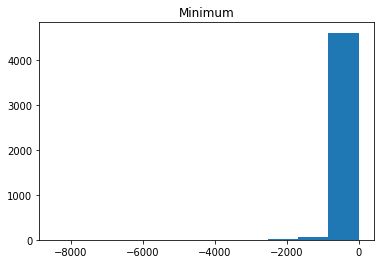

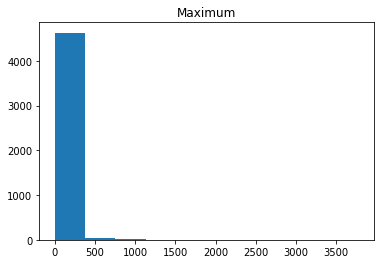

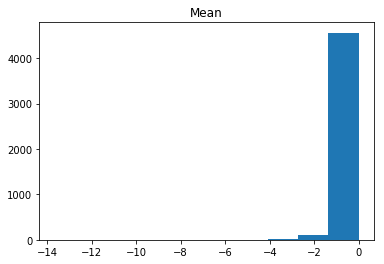

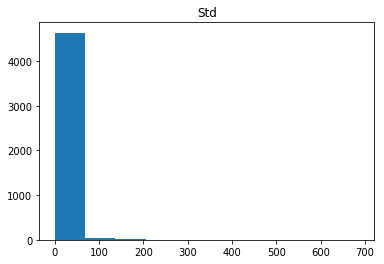

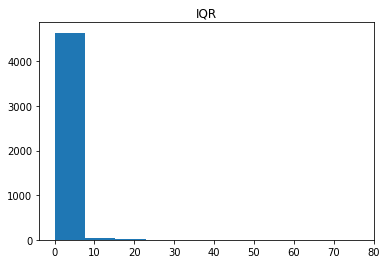

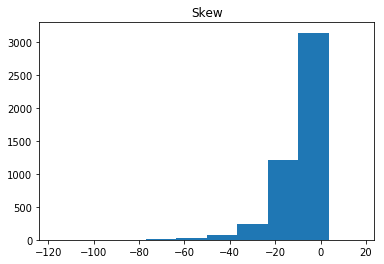

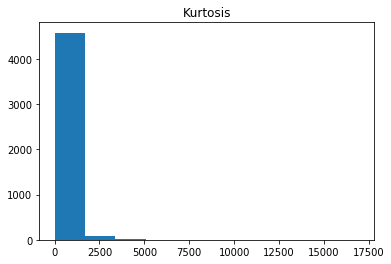

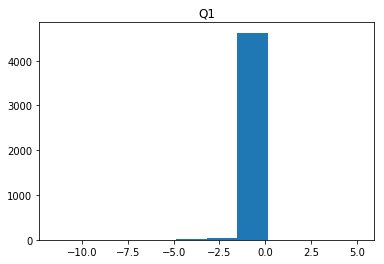

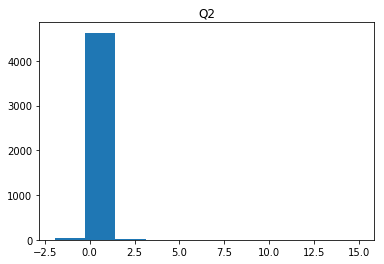

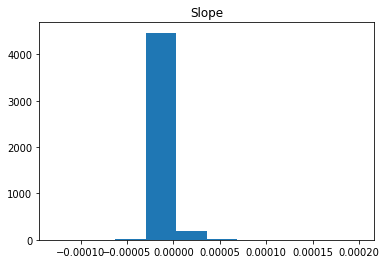

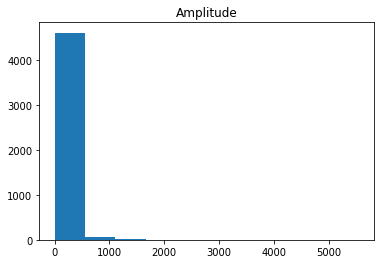

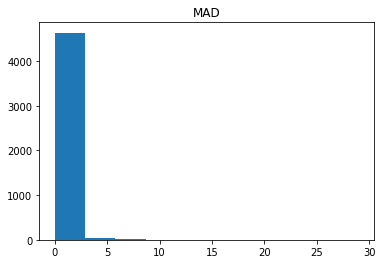

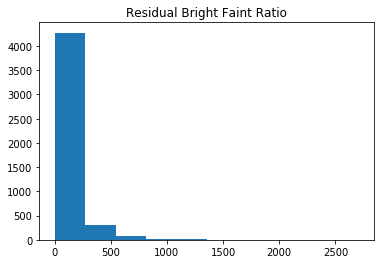

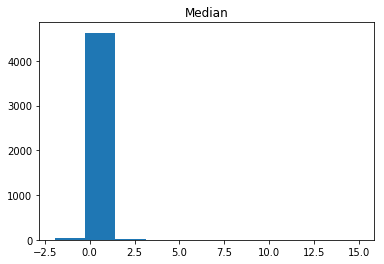

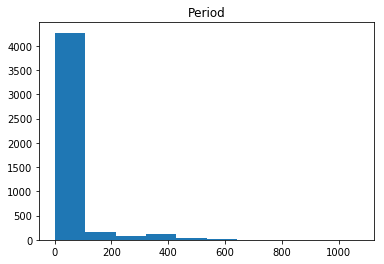

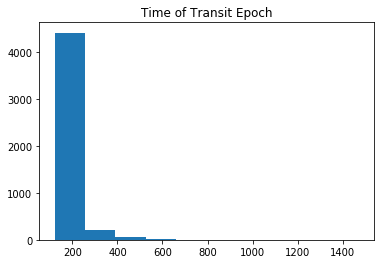

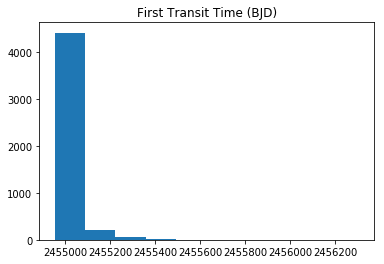

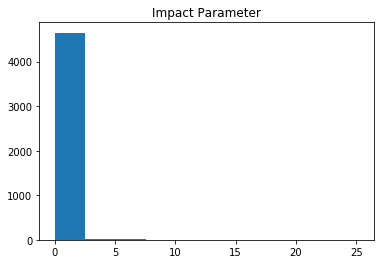

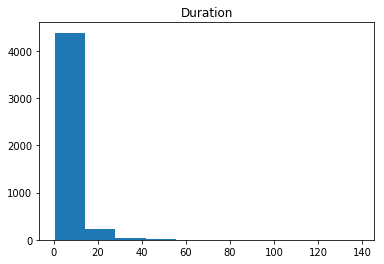

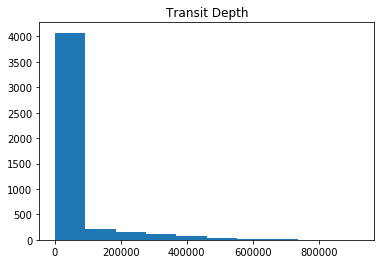

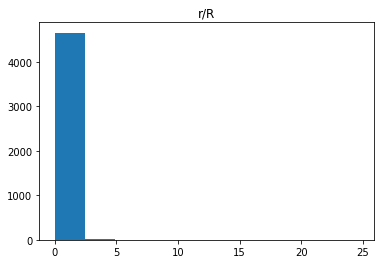

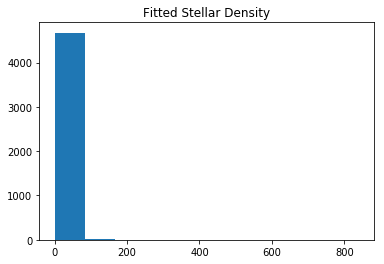

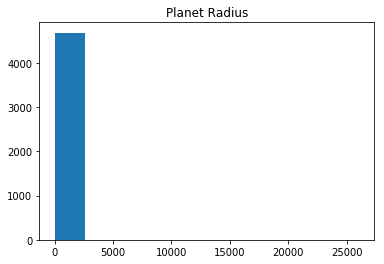

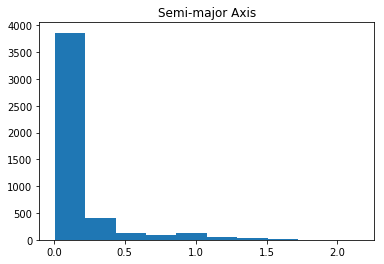

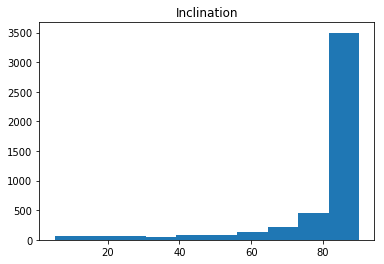

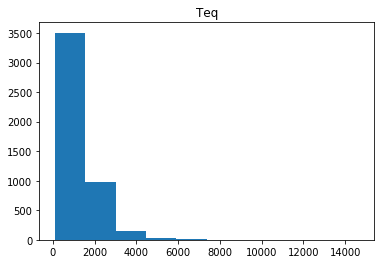

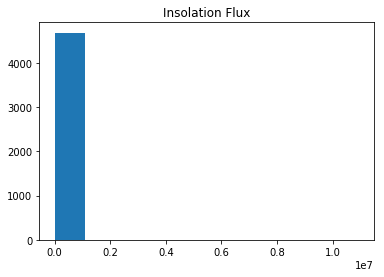

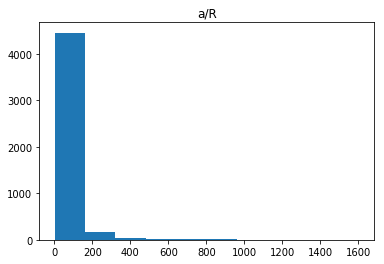

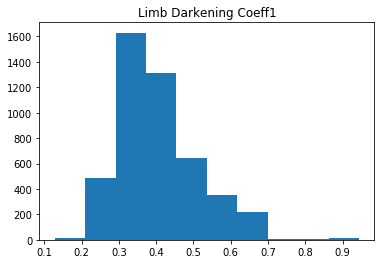

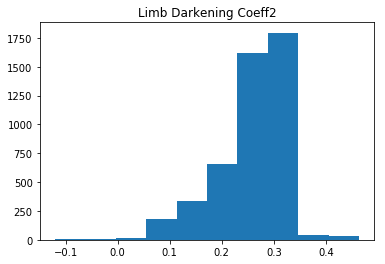

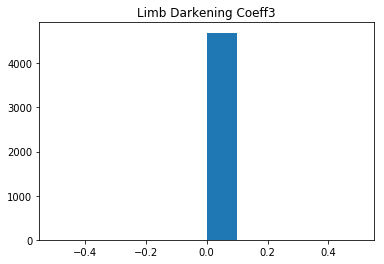

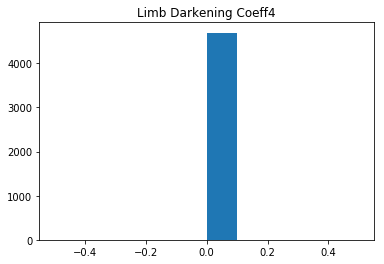

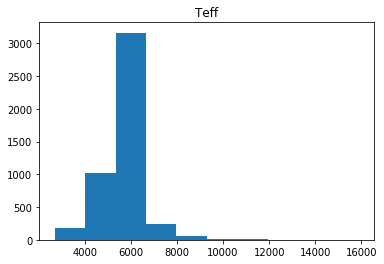

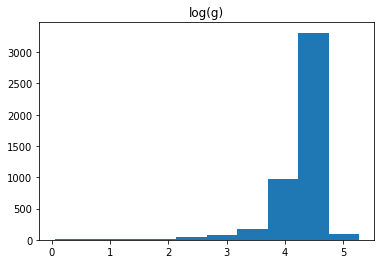

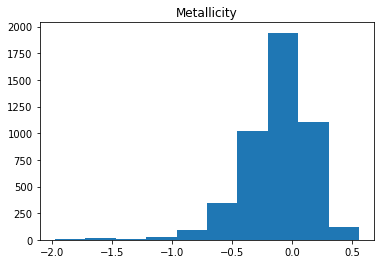

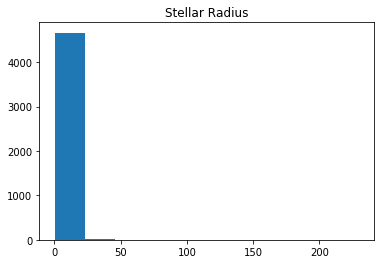

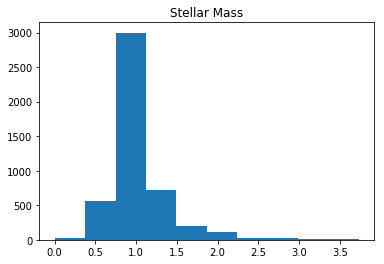

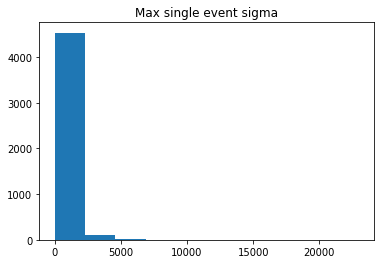

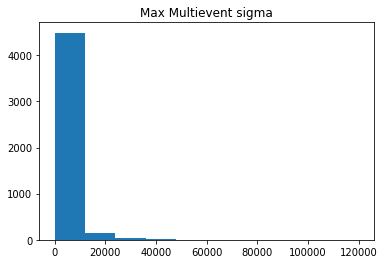

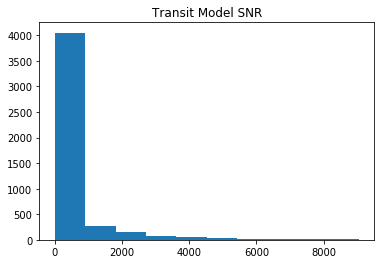

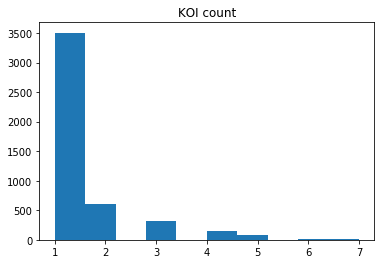

In [0]:
import matplotlib.pyplot as plt
for column in columns_names:
    plt.hist(df_X_train[column])
    plt.title(column)
    # plt.ylabel("Bikes")
    plt.show()

**b)** Escale los datos para ser trabajados por el modelo de aprendizaje, indique la importancia de éste paso. Además cree un conjunto de validación extrayendo un cierto porcentaje del conjunto de entrenamiento, por ejemplo el 20% manteniendo el desbalanceo de clases (*split* stratificado).

In [0]:
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=1)

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled =  scaler.transform(X_test)

**c)** Muestre en un gráfico la función objetivo (*cross entropy*) para el conjunto de entrenamiento y de validación *vs* número de *epochs* de entrenamiento, para una red *feedforward* de 3 capas, con 256 unidades ocultas y función de activación sigmoidal. Entrene la red usando gradiente descendente estocástico con tasa de aprendizaje (*learning rate*) 0.01 y 100 *epochs* de entrenamiento. Comente. Si observa divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento. Compare el efecto de variar la función de activación a **ReLU** ¿Qué observa en la convergencia del modelo?

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
EPOCHS = 100

def graph_loss_vs_epochs(hist, epoch):
  loss_b = np.array(hist.history['loss'])
  epochs_b = np.arange(epoch)

  plt.plot(epochs_b, loss_b)
  plt.title('Number of epochs vs NN error')
  plt.xlabel('epochs')
  plt.ylabel('loss (cross entropy)')
  plt.show() 

Using TensorFlow backend.


In [0]:
model_sigmoid = Sequential()
model_sigmoid.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model_sigmoid.add(Dense(1, kernel_initializer='uniform',activation="sigmoid")) #this should be mantained
model_sigmoid.compile(optimizer=SGD(lr=0.01),loss='binary_crossentropy')
hist_1 = model_sigmoid.fit(X_train_scaled, y_train, epochs=EPOCHS, verbose=0, validation_data=(X_val_scaled, y_val))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


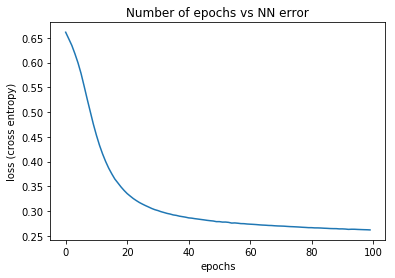

In [0]:
graph_loss_vs_epochs(hist_1, EPOCHS)

In [0]:
model_relu = Sequential()
model_relu.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model_relu.add(Dense(1, kernel_initializer='uniform',activation="relu")) #this should be mantained
model_relu.compile(optimizer=SGD(lr=0.01),loss='binary_crossentropy')
hist_2 = model_relu.fit(X_train_scaled, y_train, epochs=EPOCHS, verbose=0, validation_data=(X_val_scaled, y_val))

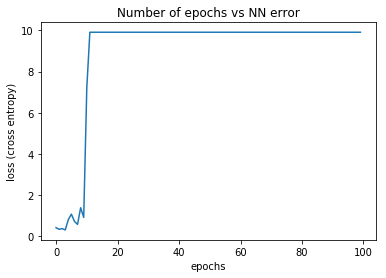

In [0]:
graph_loss_vs_epochs(hist_2, EPOCHS)

Finalmente compare a través de una métrica de desempeño sobre el conjunto de pruebas, en este caso como trabajamos un problema desbalanceado, mida *f1 score weighted*, comente sobre esta decisión ¿Es esperable la diferencia entre relu y sigmoidal en base a los gráficos realizados?

In [0]:
from sklearn.metrics import f1_score
import keras
import math
print("F1 Score Sigmoid: " + str(f1_score(y_test,model_sigmoid.predict_classes(X_test_scaled),average='weighted')))
print("F1 Score ReLu:    " + str(f1_score(y_test,model_relu.predict_classes(X_test_scaled),average='weighted')))

F1 Score Sigmoid: 0.8610619003483408
F1 Score ReLu:    0.1608802195836451


**d)** Repita **c)** variando la tasa de aprendizaje (*learning rate*) en un rango sensible. Comente. Si observa divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento o para alguna de las dos funciones de activación experimentadas.

In [0]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))

In [0]:
def step_decay(epoch):
    n_lr = 20
    epoch_decay = 5
    lear_rate = np.linspace(0,1,n_lr)
    l_rate = math.floor(epoch/epoch_decay) if epoch < 100 else 19
    return lear_rate[l_rate]

In [0]:
def create_sequential_hist(n_epochs, activation):
    history = LossHistory()
    l_rates = LearningRateScheduler(step_decay)
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation=activation))
    model.add(Dense(1, kernel_initializer='uniform',activation=activation)) #this should be mantained
    model.compile(optimizer=SGD(lr=0.1),loss='binary_crossentropy')
    return model.fit(X_train_scaled, y_train, epochs=n_epochs, verbose=0, callbacks=[history, l_rates], validation_data=(X_val_scaled, y_val))

In [0]:
def epochs_and_loss_values(n_epochs, activation):
    hist = create_sequential_hist(n_epochs, activation)
    loss_b = np.array(hist.history['loss'])
    epochs_b = np.arange(n_epochs)
    return epochs_b, loss_b

In [0]:
def multi_graph_loss_vs_epochs(n_epochs, activation):
    epochs_b, loss_b = epochs_and_loss_values(n_epochs, activation)
    plt.plot(epochs_b, loss_b)
    plt.title('Number of epochs vs NN error')
    plt.xlabel('epochs')
    plt.ylabel('loss (cross entropy)')
    plt.show() 

In [0]:
import numpy as np
from keras.callbacks import LearningRateScheduler

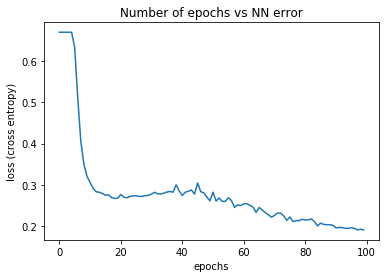

In [0]:
multi_graph_loss_vs_epochs(EPOCHS, 'sigmoid')

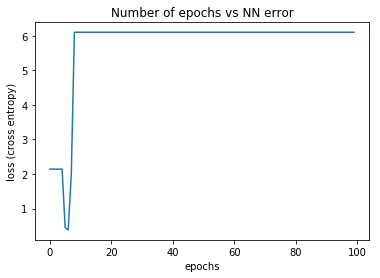

In [0]:
multi_graph_loss_vs_epochs(EPOCHS, 'relu')

**e)** Entrene los modelos considerados en c) usando *progressive decay*. Compare y comente.

In [0]:
def create_sequential_hist(n_epochs, activation):
    n_decay = 10
    lear_decay = np.logspace(-6,0,n_decay)
    sgd = SGD(lr=0.2, decay=1e-6)
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation=activation))
    model.add(Dense(1, kernel_initializer='uniform',activation=activation)) #this should be mantained
    model.compile(optimizer=sgd,loss='binary_crossentropy')
    return model.fit(X_train_scaled, y_train, epochs=100, verbose=0, validation_data=(X_val_scaled, y_val))

In [0]:
hist = create_sequential_hist(EPOCHS, 'relu')

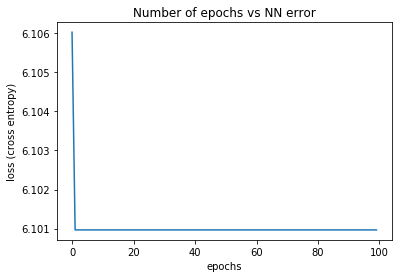

In [0]:

graph_loss_vs_epochs(hist, 100)


In [0]:
hist = create_sequential_hist(EPOCHS, 'sigmoid')

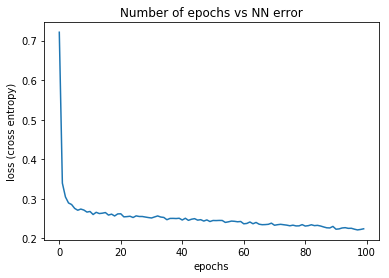

In [0]:
graph_loss_vs_epochs(hist, 100)

**f)** Entrene los modelos considerados en c) usando *momentum* [[3]](#refs). Experimente usando *momentum* clásico y *momentum* de Nesterov. ¿Observa un mejor resultado final? ¿Observa una mayor velocidad de convergencia sobre el conjunto de entrenamiento? ¿Sobre el conjunto de validación?

In [0]:
def create_sequential_hist(sgd, n_epochs, activation):
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation=activation))
    model.add(Dense(1, kernel_initializer='uniform',activation=activation)) #this should be mantained
    model.compile(optimizer=sgd,loss='binary_crossentropy')
    return model.fit(X_train_scaled, y_train, epochs=n_epochs, verbose=0, validation_data=(X_val_scaled, y_val))

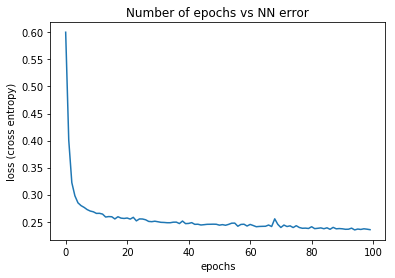

In [0]:
split_space = 21
momentum = np.linspace(0,1,split_space)
sgd = SGD(lr=0.01,momentum=0.9,nesterov=False)
hist = create_sequential_hist(sgd, EPOCHS, 'sigmoid')
graph_loss_vs_epochs(hist, 100)

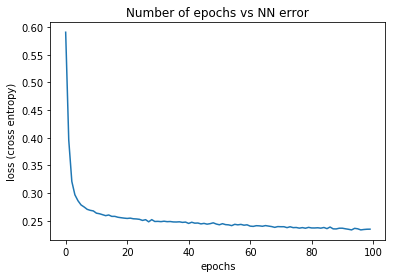

In [0]:
split_space = 21
momentum = np.linspace(0,1,split_space)
sgd = SGD(lr=0.01,momentum=0.9,nesterov=True)
hist = create_sequential_hist(sgd, EPOCHS, 'sigmoid')
graph_loss_vs_epochs(hist, 100)

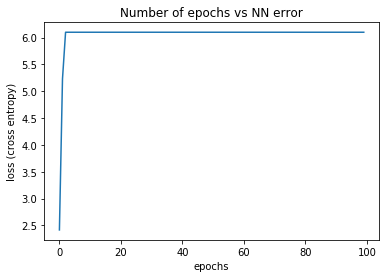

In [0]:
split_space = 21
momentum = np.linspace(0,1,split_space)
sgd = SGD(lr=0.01,momentum=0.9,nesterov=False)
hist = create_sequential_hist(sgd, EPOCHS, 'relu')
graph_loss_vs_epochs(hist, 100)

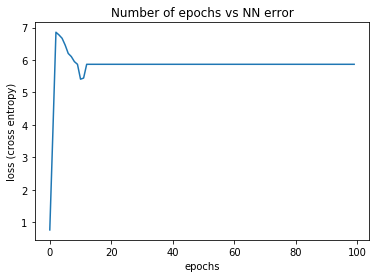

In [0]:
split_space = 21
momentum = np.linspace(0,1,split_space)
sgd = SGD(lr=0.01,momentum=0.9,nesterov=True)
hist = create_sequential_hist(sgd, EPOCHS, 'relu')
graph_loss_vs_epochs(hist, 100)

**g)** Vuelva a entrenar los modelos considerados en c) utilizando SGD en mini-*batches*. Experimente con diferentes tamaños del *batch*. Comente sobre eficacia de convergencia (converge en menor número de *epochs*) *vs* eficiencia computacional (tiempo en converger o por *epoch*).

In [0]:
class NBatchLogger(keras.callbacks.Callback):
    def __init__(self,display=100):
        self.seen = 0
        self.display = display

    def on_batch_end(self,batch,logs={}):
        self.seen += logs.get('size', 0)

In [0]:
def create_sequential_hist(n_epochs, activation):
    n_batches = 21
    batch_sizes = NBatchLogger(np.round(np.linspace(1,X_train_scaled.shape[0],n_batches)))
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation=activation))
    model.add(Dense(1, kernel_initializer='uniform',activation=activation)) #this should be mantained
    model.compile(optimizer=SGD(lr=0.1),loss='binary_crossentropy')
    return model.fit(X_train_scaled,y_train,verbose=0, batch_size=50,epochs=n_epochs, callbacks=[batch_sizes], validation_data=(X_val_scaled, y_val))

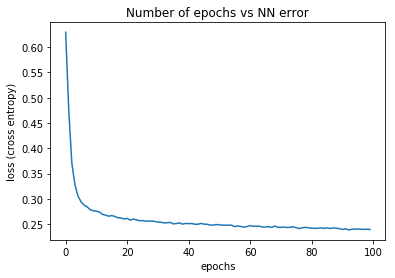

In [0]:
hist = create_sequential_hist(EPOCHS, 'sigmoid')
graph_loss_vs_epochs(hist, 100)

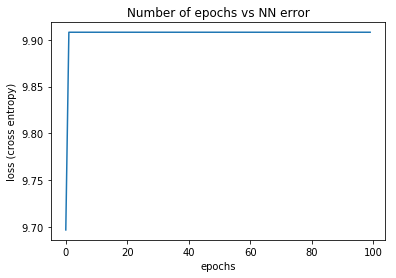

In [0]:
hist = create_sequential_hist(EPOCHS, 'relu')
graph_loss_vs_epochs(hist, 100)

**h)** Entrene los modelos obtenidos en c) utilizando estrategias modernas para adaptar la tasa de aprendizaje. Compare los desempeños de *adagrad, adadelta, RMSprop* y *adam*, ofrecidos en __[keras optimizer](https://keras.io/optimizers/)__. ¿Se observa en algún caso un mejor resultado final? ¿Se observa en algún caso una mayor velocidad de convergencia sobre el dataset de entrenamiento? ¿Sobre el dataset de validación?

In [0]:
def create_sequential_hist(optimizer, n_epochs, activation):   
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation=activation))
    model.add(Dense(1, kernel_initializer='uniform',activation=activation)) #this should be mantained
    model.compile(optimizer=optimizer,loss='binary_crossentropy')
    return model.fit(X_train_scaled,y_train,verbose=0, batch_size=50,epochs=n_epochs, validation_data=(X_val_scaled, y_val))

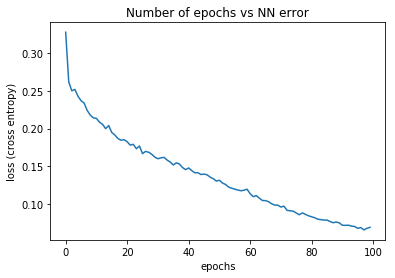

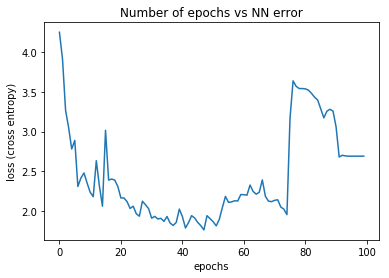

In [0]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
moptimizer =  Adam(lr=0.01)
hist = create_sequential_hist(moptimizer, EPOCHS, 'sigmoid')
graph_loss_vs_epochs(hist, 100)
hist = create_sequential_hist(moptimizer, EPOCHS, 'relu')
graph_loss_vs_epochs(hist, 100)

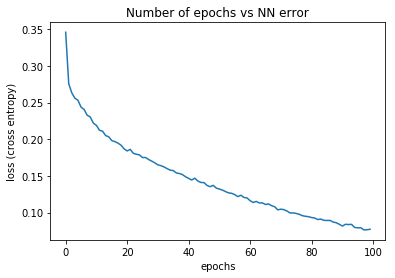

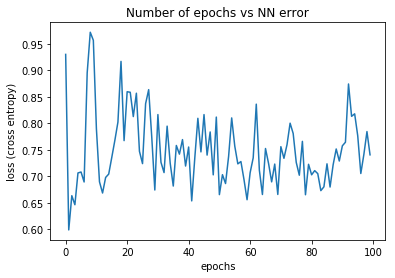

In [0]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
moptimizer = RMSprop(lr=0.01)
hist = create_sequential_hist(moptimizer, EPOCHS, 'sigmoid')
graph_loss_vs_epochs(hist, 100)
hist = create_sequential_hist(moptimizer, EPOCHS, 'relu')
graph_loss_vs_epochs(hist, 100)

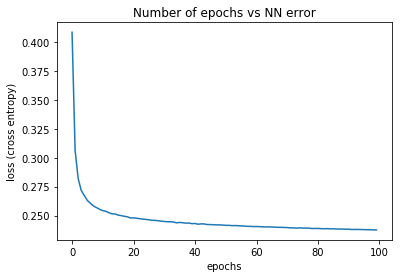

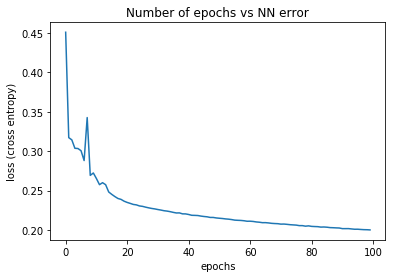

In [0]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
moptimizer = Adagrad(lr=0.01)
hist = create_sequential_hist(moptimizer, EPOCHS, 'sigmoid')
graph_loss_vs_epochs(hist, 100)
hist = create_sequential_hist(moptimizer, EPOCHS, 'relu')
graph_loss_vs_epochs(hist, 100)

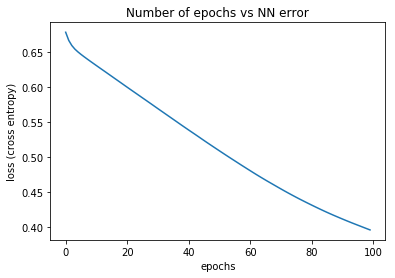

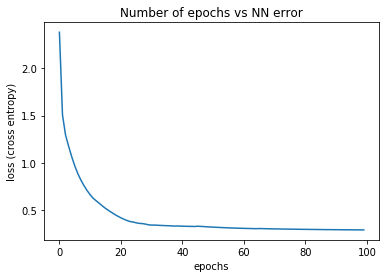

In [0]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
moptimizer = Adadelta(lr=0.01)
hist = create_sequential_hist(moptimizer, EPOCHS, 'sigmoid')
graph_loss_vs_epochs(hist, 100)
hist = create_sequential_hist(moptimizer, EPOCHS, 'relu')
graph_loss_vs_epochs(hist, 100)

**i)** Entrene los modelos obtenidos en c) utilizando regularizadores clásicos $l_1$ y $l_2$ (*weight decay*). Compare los desempeños de prueba obtenidos antes y después de regularizar. Experimente con distintos valores del parámetro de regularización y comente. Además evalúe el efecto de regularizar solo la primera capa *vs* la segunda, comente. *Recuerde que la regularización se debe añadir a cada capa separadamente* ¿Dónde le parece más importante aplicar?

In [0]:
from keras.layers import Activation
from keras.regularizers import l1,l2
def create_sequential_hist(l, n_epochs, activation):
  model = Sequential()
  model.add(Dense(256,input_dim=X_train_scaled.shape[1],kernel_initializer='uniform',kernel_regularizer=l))
  model.add(Activation(activation)) #and relu
  model.add(Dense(1, kernel_initializer='uniform',kernel_regularizer=l))
  model.compile(optimizer=SGD(lr=0.1),loss='binary_crossentropy')
  return model.fit(X_train_scaled,y_train,verbose=0, batch_size=50,epochs=n_epochs, validation_data=(X_val_scaled, y_val))

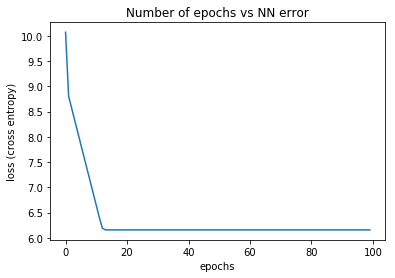

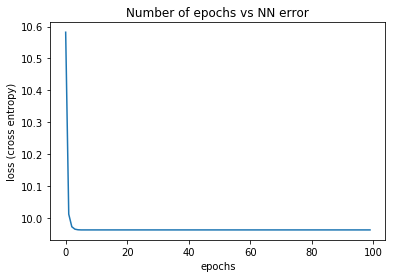

In [0]:
regularizer = l1(0.01)
hist = create_sequential_hist(regularizer, EPOCHS, 'sigmoid')
graph_loss_vs_epochs(hist, 100)
hist = create_sequential_hist(regularizer, EPOCHS, 'relu')
graph_loss_vs_epochs(hist, 100)

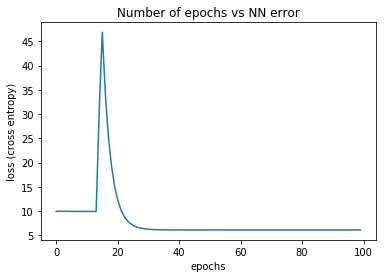

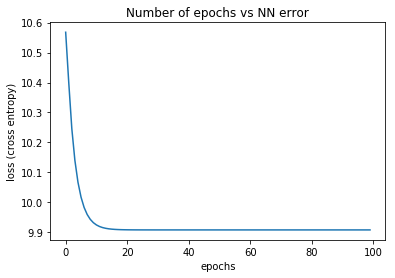

In [0]:
regularizer = l2(0.01)
hist = create_sequential_hist(regularizer, EPOCHS, 'sigmoid')
graph_loss_vs_epochs(hist, 100)
hist = create_sequential_hist(regularizer, EPOCHS, 'relu')
graph_loss_vs_epochs(hist, 100)

**j)** Elija uno de los dos modelos definidos en c) y experimente con modificar la función objetivo, que hasta ahora se lo hemos dejado a keras definir la típica *binary cross entropy*, en pos de algún objetivo que decida plantearse, por ejemplo aumentar la velocidad de convergencia (reducir más rápida la función objetivo), obtener mejor desempeño en *f1 score* u algún otro.  
*Se dejan algunos ejemplos*

In [0]:
#1. Focal loss [[4]](#refs)
#2. Cross entropy + Min entropy
#3. Cross entropy + Max entropy
#4. Kullback Leibler (KL) ó Jensen Shannon (JS) divergence [[5]](#refs)  
#5. Weighted Cross entropy  
    
from keras import backend as K
alpha = 0.25
gamma = 2
def custom_loss(value, mode): #ejemplo
  def loss(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    switch(mode):
      case 1: return-K.sum(alpha * K.pow(1. - y_pred, gamma) * K.log(y_pred))-K.sum((1-alpha) * K.pow(y_true, gamma) * K.log(1. - y_true))
      case 2: return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)+K.minimun(1. - y_true * y_pred, 0.)
      case 3: return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)+K.maximum(1. - y_true * y_pred, 0.)
      case 4: return K.sum(y_true * K.log(y_true / y_pred), axis=-1) #KL-divergence
      case 5: return value*K.mean(K.square(y_pred - y_true), axis=-1) #MSE
  return loss

In [0]:
from keras.layers import Activation
from keras.regularizers import l1,l2
def create_sequential_hist(loss, n_epochs, activation):
  model = Sequential()
  model.add(Dense(256,input_dim=X_train_scaled.shape[1],kernel_initializer='uniform'))
  model.add(Activation(activation)) #and relu
  model.add(Dense(1, kernel_initializer='uniform'))
  model.compile(loss=custom_loss,optimizer=SGD(lr=0.1))
  return model.fit(X_train_scaled,y_train,verbose=0, batch_size=50,epochs=n_epochs, validation_data=(X_val_scaled, y_val))

In [0]:
hist = create_sequential_hist(loss(1, 1), EPOCHS, 'relu')
graph_loss_vs_epochs(hist, 100)

In [0]:
hist = create_sequential_hist(loss(1, 2), EPOCHS, 'relu')
graph_loss_vs_epochs(hist, 100)

In [0]:
hist = create_sequential_hist(loss(1, 3), EPOCHS, 'relu')
graph_loss_vs_epochs(hist, 100)

In [0]:
hist = create_sequential_hist(loss(1, 4), EPOCHS, 'relu')
graph_loss_vs_epochs(hist, 100)

In [0]:
hist = create_sequential_hist(loss(1, 5), EPOCHS, 'relu')
graph_loss_vs_epochs(hist, 100)

<a id="refs"></a>
## Referencias
[1] Borucki, W. J., Koch, D. G., Basri, G., Batalha, N., Boss, A., Brown, T. M., ... & Dunham, E. W. (2011). *Characteristics of Kepler planetary candidates based on the first data set*. The Astrophysical Journal, 728(2), 117. also in: https://exoplanetarchive.ipac.caltech.edu/index.html  
[2] Bugueno, M., Mena, F., & Araya, M. *Refining Exoplanet Detection Using Supervised Learning and Feature Engineering*.  
[3] Sutskever, I., Martens, J., Dahl, G. E., & Hinton, G. E. (2013). *On the importance of initialization and momentum in deep learning*. ICML (3), 28(1139-1147), 5.  
[4] Lin, T. Y., Goyal, P., Girshick, R., He, K., & Dollár, P. (2017). *Focal loss for dense object detection*. In Proceedings of the IEEE international conference on computer vision (pp. 2980-2988).  
[5] Chen, P., Chen, Y., & Rao, M. (2008). *Metrics defined by Bregman divergences: Part 2*. Communications in Mathematical Sciences, 6(4), 927-948.  
[6] Glorot, X., & Bengio, Y. (2010, March). *Understanding the difficulty of training deep feedforward neural networks*. In Proceedings of the thirteenth international conference on artificial intelligence and statistics (pp. 249-256).   
[7] He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Delving deep into rectifiers: Surpassing human-level performance on imagenet classification*. In Proceedings of the IEEE international conference on computer vision (pp. 1026-1034).    
[8] Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). *Dropout: a simple way to prevent neural networks from overfitting*. The Journal of Machine Learning Research, 15(1), 1929-1958.  
[9] Ioffe, S., & Szegedy, C. (2015). Batch normalization: *Accelerating deep network training by reducing internal covariate shift*. arXiv preprint arXiv:1502.03167.  
[10] Krizhevsky, A., Nair, V., & Hinton, G. (2014). *The CIFAR-10 dataset*. online: http://www.cs.toronto.edu/kriz/cifar.html , 4.  
[11] Bengio, Y. (2012, June). *Deep learning of representations for unsupervised and transfer learning*. In Proceedings of ICML Workshop on Unsupervised and Transfer Learning (pp. 17-36).  
[12] Simonyan, K., & Zisserman, A. (2014). *Very deep convolutional networks for large-scale image recognition*. arXiv preprint arXiv:1409.1556.  
[13] Ruder, S. (2017). *An overview of multi-task learning in deep neural networks*. arXiv preprint arXiv:1706.05098.  